# Chapter 19: The Policy Gradient Method in Breakout






New Skills in This Chapter:

• Creating a policy neural network with multiple outputs

• Modify the rewards in the Atari Breakout game

• Training and testing a policy network for Breakout

• Zeroing in on certain time steps of a game episode

***
*An idea is always a generalization, and generalization is a property of thinking. To generalize means to think.*<br>
***
--Georg Wilhelm Friedrich Hegel

***

In [1]:
import os

os.makedirs("files/ch19", exist_ok=True)

# 19.1. Get Started with the Breakout Game


## 19.1.1. The Breakout Game


In [2]:
import gym
env = gym.make("Breakout-v0")
env.reset()
env.render()

True

In [3]:
actions = env.action_space
print(f"The action space for Breakout is {actions}")
obs_space = env.observation_space
print(f"The observation space for Breakout {obs_space}")

The action space for Breakout is Discrete(4)
The observation space for Breakout Box(210, 160, 3)


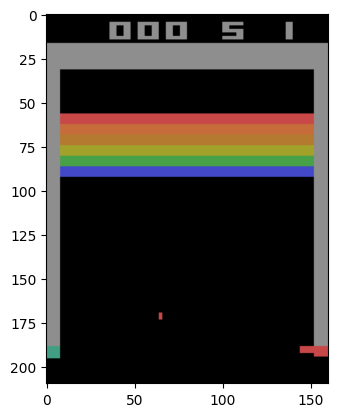

In [4]:
import matplotlib.pyplot as plt
import numpy as np

env.reset()
# Run 20 steps so the ball appears in the picture
for _ in range(20):
    action = np.random.choice([0,1,2,3])
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()

If you don't see a ball in the picture, rerun the above cell until you see a ball.

## 19.1.2. Preprocess the Game Frames

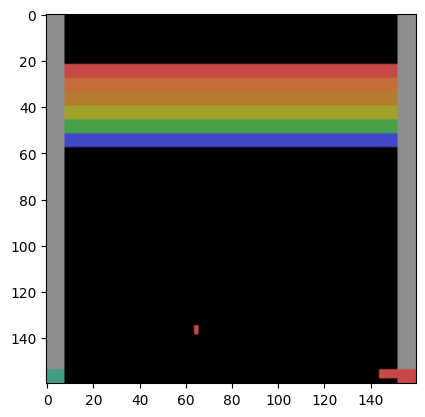

In [5]:
obs_cropped = obs[35:195]
plt.imshow(obs_cropped)
plt.show()

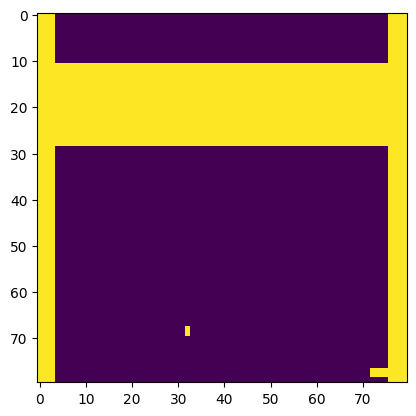

In [6]:
obs_downsized=obs_cropped[::2,::2,0]
obs_downsized[obs_downsized==144]=0
obs_downsized[obs_downsized==109]=0
obs_downsized[obs_downsized!=0]=1
plt.imshow(obs_downsized)
plt.show()

## 19.1.3. Obtain the Difference of Two Game Windows


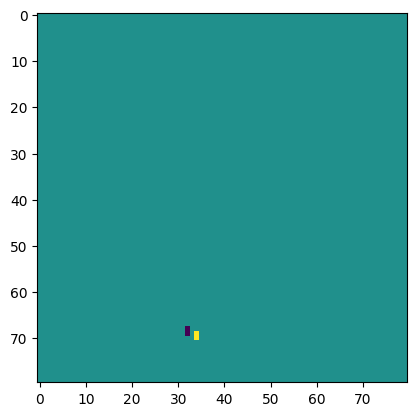

In [7]:
from utils.ch19util import prepro

next_obs, reward, done, info = env.step(3)
next_obs_downsized = prepro(next_obs).reshape(80,80)

dif = next_obs_downsized - obs_downsized
plt.imshow(dif)
plt.show()

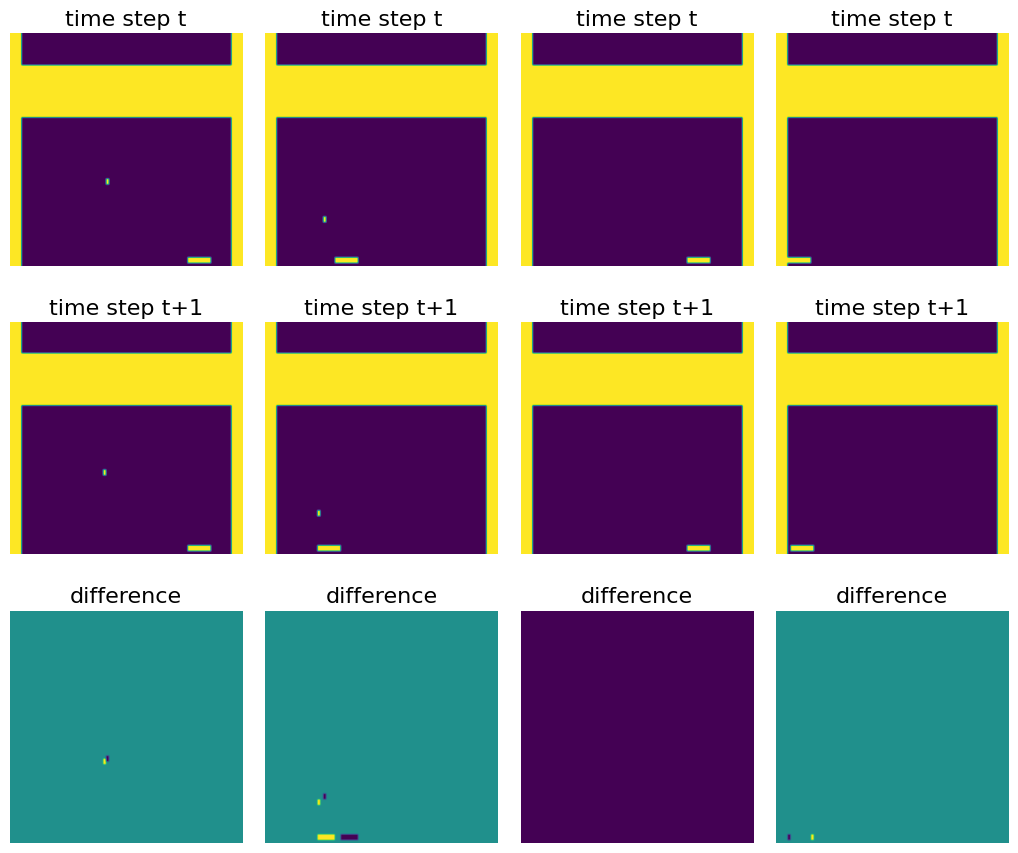

In [8]:
from utils.ch19util import dif_breakout

dif_breakout()

# 19.2. Train the Policy Gradient Model


## 19.2.1. Changes Needed


In [9]:
import gym
env = gym.make("Breakout-v0")
env.reset()
env.render()

while True:
    action = np.random.choice([0,1,2,3])
    obs, reward, done, info = env.step(action)
    print(reward, done, info)
    env.render()
    if info["ale.lives"]==4:
        break
env.close()

Exception ignored in: <function SimpleImageViewer.__del__ at 0x000001FD4D1D6DC0>
Traceback (most recent call last):
  File "C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\envs\classic_control\rendering.py", line 369, in __del__
    self.close()
  File "C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\envs\classic_control\rendering.py", line 365, in close
    self.window.close()
  File "C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\hlliu2\Anaconda3\envs\MLA\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001FD48062770; to 'Win32Window' at 0x000001FD47B35520>


0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 4}


## 19.2.2. Create A Policy Network


In [10]:
H = 200 
learning_rate = 1e-4
gamma = 0.99 
decay_rate = 0.99 
D = 80 * 80 
num_actions = 4

In [11]:
# Define the one-hot encoder and softmax functions
def onehot_encoder(action):
    onehot=np.zeros((1,num_actions))
    onehot[0,action]=1
    return onehot

def softmax(x):
    xi=np.exp(x)
    return xi/xi.sum() 

In [12]:
def policy_forward(model,x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h 

In [13]:
def policy_backward(model,eph, epdlogp, epx):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

In [14]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        if r[t] != 0: 
            running_add = 0 
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

## 19.2.3. Train the Policy Gradient Agent in Breakout

In [15]:
def policy_breakout(test=False,resume=False,render=False,\
                    cutoff=25):
    rewards=deque(maxlen=100)
    env = gym.make("Breakout-v0")
    if test:
        batch_size=1
    else:
        batch_size=10
    if resume==True or test==True:
        model=pickle.load(open('files/ch19/pg_breakout.p','rb'))
    else:
        model={}
        model['W1']=np.random.randn(H,D) / np.sqrt(D) 
        model['W2']=np.random.randn(num_actions,H) / np.sqrt(H) 
    episode_count=0
    while True:
        batchrewards=create_batch(env,render,model,batch_size)
        rewards += batchrewards
        episode_count += batch_size
        running_reward=np.mean(np.array(rewards)) 
        if episode_count % 100 == 0 or test==True:
            template = "running reward: {:.6f} at episode {}"
            print(template.format(running_reward,episode_count))
            pickle.dump(model,\
                        open('files/ch19/pg_breakout.p','wb'))
        if test==False and running_reward>=cutoff:  
            break
        if test==True and episode_count>=3:  
            break         
    env.close()   

In [16]:
from utils.ch19util import policy_breakout
env.close()
policy_breakout(test=False,resume=False,render=True,cutoff=-5)

In [17]:
policy_breakout(test=False,resume=False,render=False,cutoff=40)

The training takes about about 24 hours and 500,000 episodes, or you can download
the trained model pg_breakout.p from the book’s GitHub repository. If the agent can
have an average score of 40, you can capture an episode of game in which the agent
digs a tunnel at the side of the wall.

# 19.3. Test the Policy Gradient Agent in Breakout


## 19.3.1. Test the Trained Policy Gradient Agent
First, we test three games by calling the *policy_breakout()* function and setting the *test* argument to *True*:

In [18]:
policy_breakout(test=True,resume=True,render=True)

running reward: 38.000000 at episode 1
running reward: 34.000000 at episode 2
running reward: 26.333333 at episode 3


## 19.3.2. Search for Successful Episodes

In [19]:
from utils.ch19util import policy_forward
import pickle

while True:
    frames = []
    observation = env.reset()
    prev_x = None
    reward_sum=0 
    while True:
        cur_x = prepro(observation)
        x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
        aprob, h = policy_forward(model,x)
        action = np.random.choice([0,1,2,3], p=aprob)
        observation, reward, done, info = env.step(action)
        env.render()
        reward_sum += reward
        frames.append(observation)
        if done: 
            print(f"the score is {reward_sum}")
            break
    if reward_sum>=100:
        file=f'files/ch19/above100.p'
        pickle.dump(frames, open(file,'wb'))  
        break
    env.close()

# 19.4 Zero in on Interesting Time Steps


## 19.4.1. Animate Ineresting Time Steps


We’ll first use two episodes that I have recorded: download the
file above100.zip from the book’s GitHub repository. Unzip it and you’ll see two files:
above100a.p and above100b.p.

In [20]:
frames=pickle.load(open('files/ch19/above100a.p','rb'))
for i in range(len(frames)):
    frame=frames[i]
    plt.imshow(frame)
    plt.savefig(f"files/ch19/frame{i}.png")

In [21]:
import imageio

imageio.mimsave("files/ch19/tunnel_a.gif",frames[800:-10],duration=4)

<img src="https://gattonweb.uky.edu/faculty/lium/ml/episode84.gif" />

In [22]:
images = pickle.load(open('files/ch19/above100b.p','rb'))

imageio.mimsave("files/ch19/tunnel_b.gif", images[600:],duration=4)

<img src="https://gattonweb.uky.edu/faculty/lium/ml/episode606.gif" />

## 19.4.2. Subplots of the Interesting Time Steps

In [23]:
plots=frames[880::2]

Then we plot them into a five by five matrix

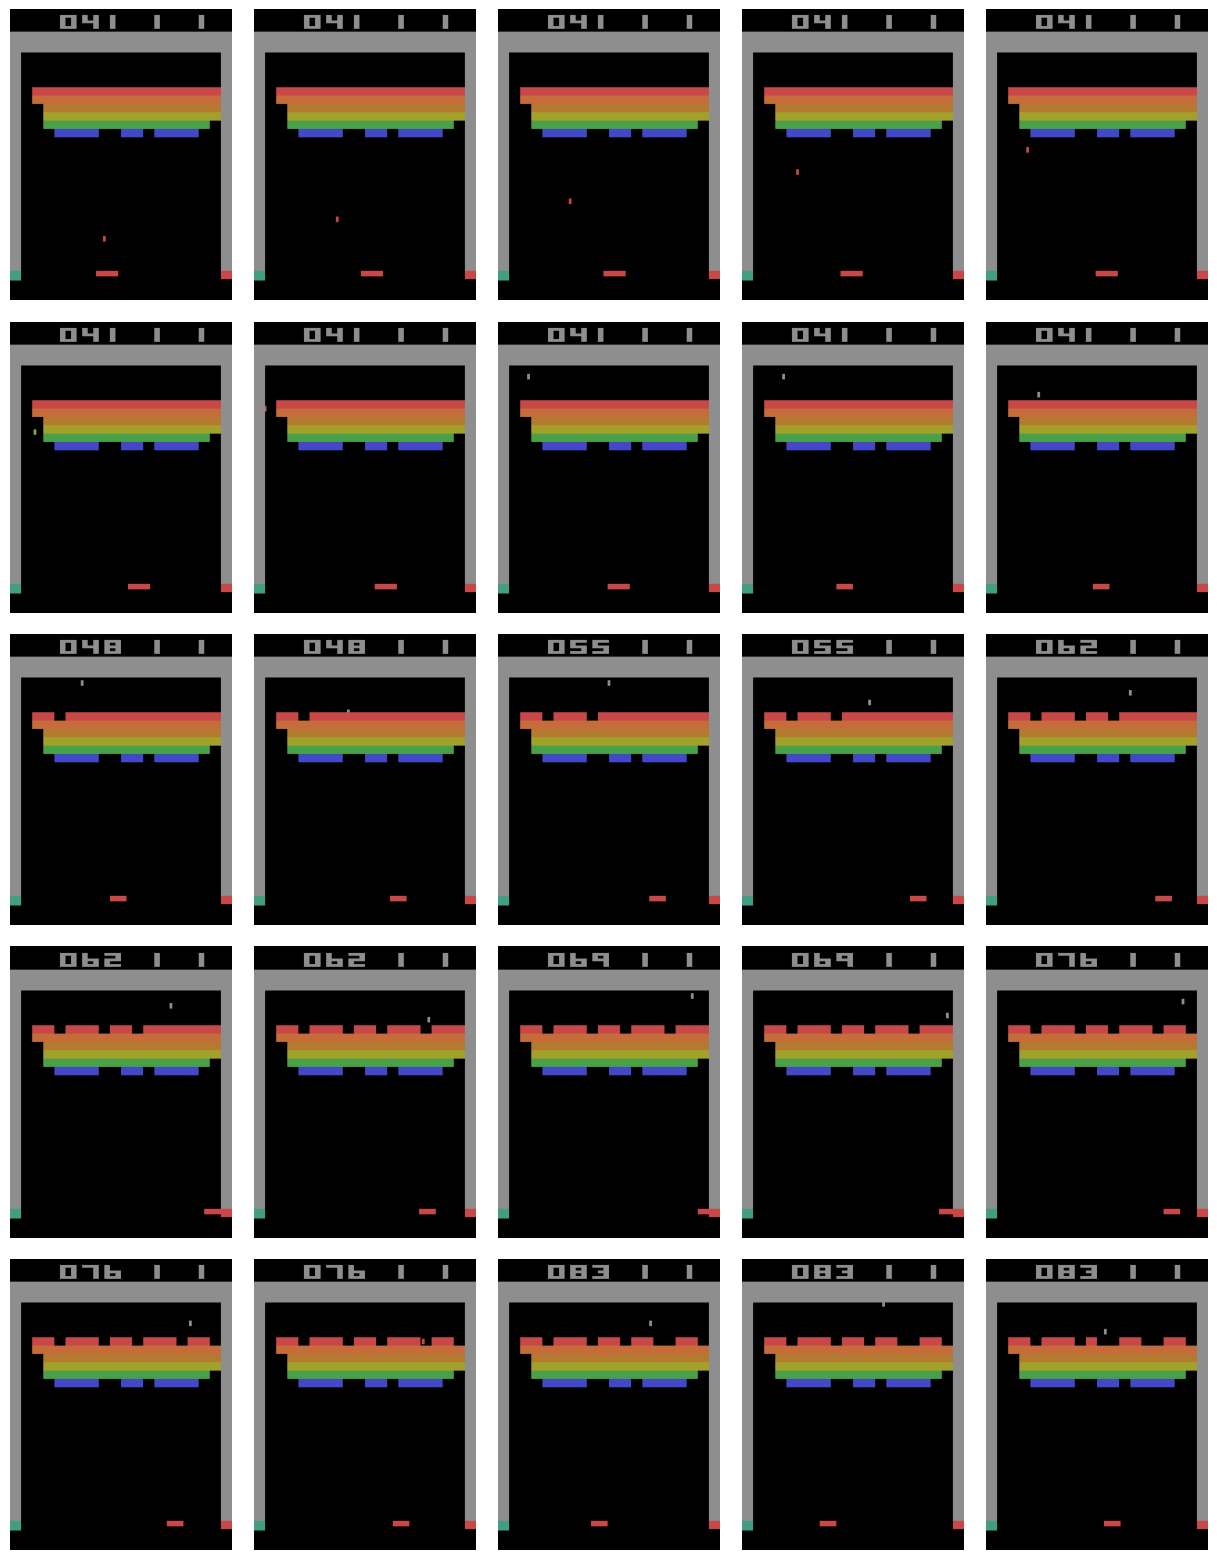

In [24]:
plt.figure(figsize=(12,16),dpi=100)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(plots[i+1])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
left=0.001, hspace=-0.1,wspace=0.1)
plt.savefig("files/ch19/tunnel.png")